## Demonstating Ethnic Bias in Neural Networks

This scenario is an exploration of ethnic bias in a simplified sentiment analysis algorithm. The purpose of this is to; demonstrate and help to understand the issues of bias in machine learning and how they can unintentionally arise; to start to explore possible ethical dilemmas that could form part of a neuroevolution scenario, and to develop my own familiarity with Word2Vec.  It draws heavily on Speer (2017).

### The process

For this problem we take a text source, this could be social media, a specific website or group of websites, or a word vector dataset.  In this case, we're using Google News, as it provides a broad selection of content, includes various publishers and topics, and should contain less explicit hate speech that might otherwise skew results (though I haven't confirmed this).

Next, we add a lexicon of positive words and another of negative words. For example, words such as abound, adequate and accurate are considered to express a positive sentiment; words such as abnormal, abrasive or abrupt are considered to express a negative sentiment.

The 3rd step is to create a series of lists of words that are representative of specific groups of people.  In this case, we're using common first names grouped by their associated ethnicity, e.g. Emily = White, Juan = Hispanic etc.

With these datasets, we can now use a neural network to do sentiment analysis on each of the names in each of the groups.  For this, we use Word2vec, a common NLP neural network for word associations. This works by representing words as vectors in a multidimensional space. The closer in proximity words are in this vector space, the more similar their meaning.  The result of this is a score for each of the names.  Names that occur more often alongside words in our positive lexicon will end up with a net positive score, the higher the score the stronger the positive sentiment.  Names that frequently occur alongside words from our negative lexicon will have a net negative score, the lower the score the stronger the negative sentiment.

Finally, we tally the scores for each group and plot them to see the sentiment for each of the ethnic/gender groups. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import statsmodels.formula.api
import conceptnet5

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from conceptnet5.vectors.formats import load_word2vec_bin

# Configure graphs
%matplotlib inline
sns.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)
sns.set_theme()

### Create Lexicon
The first step is to create the lexicons of words and their sentiment.  Bing Liu, of the University of Illinois, has published a list of approx 6,800 words categorised by whether they have a positive or negative sentiment (see https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html).

In [2]:
def load_lexicon(filename):
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')

### Create Groupings of Names by Ethnicity
There is no single list of names so a varity of sources have been used, including ONS name statistics and baby name websites.  The lists here are modified from the original work to be more uniform.  Each ethnic grouping now contains 25 male and 25 female names.  Some names that have mulitple meanings were causing outliers (e.g. 'Chip'), these have been replaced.

In [3]:
NAMES_BY_ETHNICITY = {
    'White': [
        'Harry', 'Josh', 'Alan', 'Frank', 'Ian',
        'Justin','Ryan', 'Andrew', 'Fred', 'Jack',
        'Matthew', 'Stephen', 'Brad', 'Greg', 'Paul', 
        'Jonathan', 'Peter', 'Oliver', 'George', 'Arthur',
        'Luke', 'Scott', 'Thomas', 'Leo', 'Charlie'
        
        'Amanda','Courtney', 'Heather', 'Melanie', 'Sarah',
        'Amber', 'Grace', 'Katie','Meredith', 'Shannon',
        'Rosie', 'Charlotte', 'Sophie', 'Nancy', 'Stephanie',
        'Amelia', 'Ellen', 'Lauren', 'Peggy', 'Olivia',
        'Phoebe', 'Emily', 'Megan', 'Rachel', 'Wendy'
    ],
    
    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo',
        'Alphonse', 'Jerome','Leroy', 'Rasaan', 'Torrance',
        'Darnell', 'Lamar', 'Lionel', 'Rashaun', 'Tyree',
        'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone',
        'Everol','Lavon', 'Marcellus', 'Terryl', 'Wardell',
        
        'Aiesha', 'Lashelle', 'Nichelle','Shereen', 'Temeka',
        'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia',
        'Lakisha', 'Latoya', 'Sharise', 'Tashika', 'Yolanda',
        'Lashandra', 'Malika', 'Shavonn','Tawanda', 'Imani'
    ],
    
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge',
        'Santiago', 'Matías', 'Sebastián', 'Mateo', 'Nicolás',
        'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Carlos', 'Cesar', 'Estaban', 'Enrique', 'Felipe',
        'Gustavo', 'Hernando', 'Joaquin', 'Javier', 'Pedro'
        
        'Juana', 'Ana', 'Luisa', 'María', 'Elena',
        'Sofía', 'Isabella', 'Valentina','Camila', 'Valeria',
        'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina',
        'Zarita', 'Antonia', 'Sanchia', 'Rocia', 'Benita',
        'Carmen', 'Rosita', 'Rafaela', 'Evita', 'Estrella'
    ],
    
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef',
        'Abdullah', 'Yasin', 'Hamza', 'Ayaan', 'Syed',
        'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan',
        'Imran', 'Yazdan', 'Huzaifa', 'Meerab', 'Jafar',
        'Arman', 'Afan', 'Talha', 'Faiz', 'Ibrahim'
        
        'Mariam', 'Jana', 'Malak', 'Salma', 'Nour',
        'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
        'Khadija', 'Zainab', 'Uzma', 'Nadia', 'Meenaz'
        'Madiha',  'Wajiha', 'Faiza', 'Hafsa', 'Iqra'
    ],
    
    'Jewish/Hebrew': [
        'Eli', 'Elijah', 'Isaiah', 'Jeremiah', 'Josiah',
        'Levi', 'Seth', 'Zachary', 'Benjamin', 'Caleb',
        'Ethan', 'Gabriel', 'Noah', 'Samuel', 'Aviv',
        'Tal', 'Yonah', 'Zev' 'Alon', 'Iian',
        'Abel', 'Ezra', 'Emanuel', 'Berel', 'Malachi',
        
        'Avigail', 'Batsheva', 'Ruth', 'Ayala', 'Bethany',
        'Deborah', 'Dinah', 'Esther', 'Elish', 'Eva',
        'Ivana', 'Judith', 'Leah', 'Miriam', 'Rivka',
        'Shifra', 'Sharon', 'Tamar', 'Simone', 'Ashira',
        'Adah', 'Alona', 'Chava', 'Meital', 'Talia'
    ]
}

### Setup the model

Here we do a few things to setup the model:

<ul>
    <li>Bring in the word embeddings for the positive and negative words</li>
    <li>Setup a training/test split of 10%, which we later use to validate the model</li>
    <li>Setup an SDGClassifer from ScikitLearn to process the training vectors for 100 iterations</li>
    <li>Setup a couple of supporting functions that are used later on to display the data</li>
</ul>

In [4]:
def train_model(embs):
    global model, embeddings, name_sentiments
    embeddings = embs
    pos_vectors = embeddings.loc[pos_words].dropna()
    neg_vectors = embeddings.loc[neg_words].dropna()
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
        
    model = SGDClassifier(loss='log', random_state=0, max_iter=100)
    model.fit(train_vectors, train_targets)
    
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))
    
    name_sentiments = name_sentiment_table()
    ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
    
    return test_labels

def vecs_to_sentiment(vecs):
    predictions = model.predict_log_proba(vecs)
    return predictions[:, 1] - predictions[:, 0]

def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)

def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)
    return pd.concat(frames)

### Training the Network
Here we pull in the Google News data and use it to train the network.  Processing word vectors takes a lot of computing power, so we're using a preprocessed version of Google News for Word2Vec that is in a binary format.

We then use the test data to validate the accuracy of the model.

In [5]:
# Use a ConceptNet function to load word2vec into a Pandas frame from its binary format
w2v = load_word2vec_bin('data/word2vec-googlenews-300.bin.gz', nrows=2000000)

# word2vec is case-sensitive, so case-fold its labels
w2v.index = [label.casefold() for label in w2v.index]

# Now we have duplicate labels, so drop the later (lower-frequency) occurrences of the same label
w2v = w2v.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
test_labels = train_model(w2v)

Accuracy of sentiment: 93.67%


### Manual check
Using the table below we can sense check the sentiment scores from a subset of the test data and get a better idea of what the sentiment analyis is doing.

In [6]:
words_to_sentiment(test_labels).ix[::50]

,sentiment
index,
temerity,-6.570633
beauty,6.892461
bruise,-9.995940
thug,-11.178387
lead,4.431359
satisfying,7.497733
static,-3.143230
laud,2.707765
accomplishment,7.842620


## Visualise the Results

Here we plot the sentiments for each group.  We can clearly see the bias that the algorythm has picked up from the news data; the groups of Arab/Muslim and Black names show a very strong negative sentiment, whereas the White, Hispanic and Jewish/Hebrew name groups both show a slight positive sentiment.

<AxesSubplot:title={'center':'Sentiment for each ethnic group'}, xlabel='group', ylabel='sentiment'>

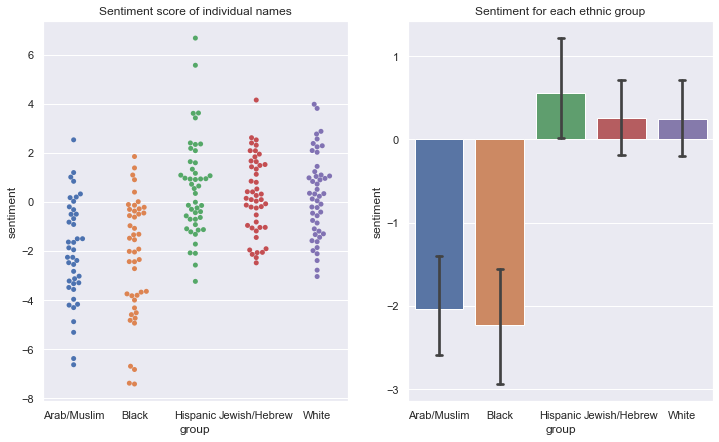

In [7]:
fig, axes = plt.subplots(1,2, figsize=(12,7))

axes[0].set_title('Sentiment score of individual names')
sns.swarmplot(ax=axes[0], x='group', y='sentiment', data=name_sentiments)

axes[1].set_title('Sentiment for each ethnic group')
sns.barplot(ax=axes[1], x='group', y='sentiment', data=name_sentiments, capsize=.1)

### See the sentiment for a subset of the names

Finally, we can take a look at some of the highest and lowest scoring names

In [8]:
name_sentiments.sort_values(['sentiment'], ascending=[False])

,sentiment,group
index,,
camila,6.670319,Hispanic
ximena,5.563370,Hispanic
shifra,4.147342,Jewish/Hebrew
lauren,3.975612,White
olivia,3.806554,White
sofía,3.618779,Hispanic
felipe,3.604928,Hispanic
mariana,3.419056,Hispanic
ellen,2.872251,White


### References

Lieu, B. [no date]. Opinion Mining, Sentiment Analysis, Opinion Extraction. Available at: https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html [Accessed: 3 February 2021].

Speer, R. 2017. How to make a racist AI without really trying | ConceptNet blog. Available at: https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/ [Accessed: 3 February 2021].